# PHÂN CỤM 

## Load data

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_1 = pd.read_csv('../data/processed/01_clean_daily_timeseries.csv.gz')
df_1.columns

Index(['Date_reported', 'Country_code', 'Country', 'WHO_region', 'New_cases',
       'New_deaths', 'Cumulative_cases', 'Cumulative_deaths', 'New_cases_MA7',
       'New_deaths_MA7', 'Growth_Rate'],
      dtype='object')

In [3]:
df_2 = pd.read_csv('../data/processed/02_country_population_summary.csv.gz')
df_2.columns

Index(['Country_code', 'Country', 'WHO_region', 'Total_Cases', 'Total_Deaths',
       'Country_code3', 'Country_clean', 'Population', 'Cases_per_1M',
       'Deaths_per_1M', 'Fatality_Rate'],
      dtype='object')

## Chuẩn bị dữ liệu tổng hợp

In [4]:
def calculate_dynamics(group):
    cases = group['New_cases_MA7'].fillna(0).values
    
   #Tốc độ tăng trưởng trung bình
    avg_growth = np.nanmean(group['Growth_Rate'])
    
    return pd.Series({
        'Avg_Growth_Rate': avg_growth
    })

print("Đang tính toán đặc trưng động học từ df_1 (có thể mất vài giây)...")
# Gom nhóm theo Country_code
dynamic_features = df_1.groupby('Country_code').apply(calculate_dynamics).reset_index()

Đang tính toán đặc trưng động học từ df_1 (có thể mất vài giây)...


C:\Users\Admin\AppData\Local\Temp\ipykernel_12120\358079121.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dynamic_features = df_1.groupby('Country_code').apply(calculate_dynamics).reset_index()


Gộp dữ liệu từ 2 DataFrame

In [5]:
df_clustering = pd.merge(df_2, dynamic_features, on='Country_code', how='inner')

print(f"Kích thước dữ liệu sau khi merge: {df_clustering.shape}")

Kích thước dữ liệu sau khi merge: (237, 12)


Tiền xử lý và chuẩn hóa

In [6]:
from sklearn.preprocessing import StandardScaler

features_for_clustering = [
    'Cases_per_1M',    
    'Deaths_per_1M',   
    'Fatality_Rate',      
    'Avg_Growth_Rate'  
]

X = df_clustering[features_for_clustering].values

# 1. Xử lý NaN (Avg_Growth_Rate có thể bị NaN ở nước nhỏ)
imputer = SimpleImputer(strategy='median') # Dùng median an toàn hơn mean khi có outlier
X_imputed = imputer.fit_transform(X)

# 2. Chuẩn hóa (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


## Chạy thuật toán để tính toán các chỉ số

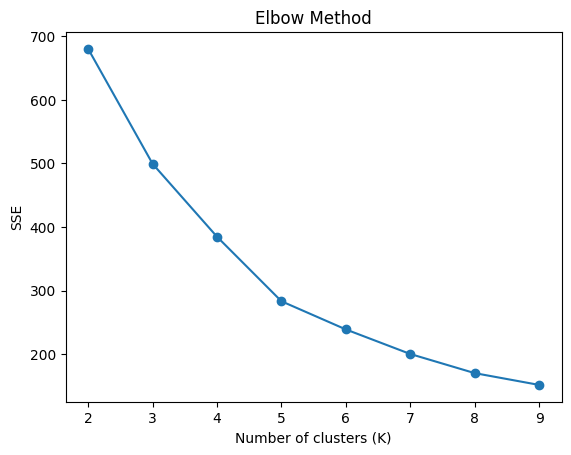

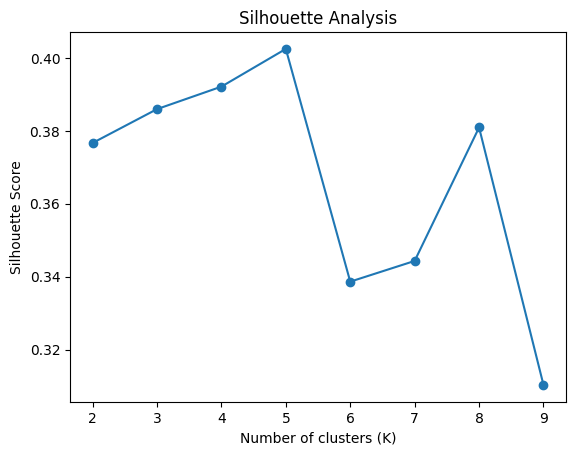

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

sse = []
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Elbow
plt.plot(K_range, sse, marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("SSE")
plt.title("Elbow Method")
plt.show()

# Silhouette
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()


Dựa trên biểu đồ Elbow Method (Hình 4.x): Tổng bình phương sai số trong cụm (SSE) giảm mạnh khi $K$ tăng từ 2 đến 5. Tại điểm $K=5$, độ dốc của đường cong bắt đầu thoải dần, cho thấy việc tăng thêm số cụm từ 5 lên 6 không mang lại sự cải thiện đáng kể về độ gọn của cụm. Do đó, $K=5$ được xác định là điểm "khuỷu tay" tiềm năng.

Dựa trên biểu đồ Silhouette Analysis (Hình 4.y): Kết quả cho thấy $K=5$ đạt hệ số cao nhất ($\approx 0.4$).

**Kết luận:** Chọn K=5 là tối ưu nhất


## Chạy K-Means với K=5

In [8]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=20)
df_clustering['Cluster'] = kmeans.fit_predict(X_scaled)

# Hiển thị số lượng quốc gia mỗi cụm
print("\nSố lượng quốc gia trong mỗi cụm:")
print(df_clustering['Cluster'].value_counts())


Số lượng quốc gia trong mỗi cụm:
Cluster
1    125
2     72
0     38
4      1
3      1
Name: count, dtype: int64


In [9]:
import pandas as pd

country_to_cluster_map = df_clustering.set_index('Country')['Cluster'].to_dict()

df_final_series = df_1.copy()

df_final_series['Cluster'] = df_final_series['Country'].map(country_to_cluster_map)

df_final_series = df_final_series.dropna(subset=['Cluster'])

# Chuyển cột Cluster về dạng số nguyên (int) cho đẹp
df_final_series['Cluster'] = df_final_series['Cluster'].astype(int)

# 1. Kiểm tra ngẫu nhiên 5 dòng để chắc chắn đã có cột Cluster
print("=== DỮ LIỆU SAU KHI GỘP CLUSTER (5 dòng đầu) ===")
display(df_final_series.head())

print("\n=== KIỂM TRA SỐ LƯỢNG DÒNG THEO CỤM ===")
print(df_final_series['Cluster'].value_counts().sort_index())

# 2. Lưu ra file CSV mới
file_name = '../data/processed/timeseries_with_clusters.csv'
df_final_series.to_csv(file_name, index=False)

print(f"\n[THÀNH CÔNG] Đã lưu file '{file_name}'.")
print("Bạn hãy dùng file này cho phần Dự báo (Mục 4.4).")

=== DỮ LIỆU SAU KHI GỘP CLUSTER (5 dòng đầu) ===


,Date_reported,Country_code,Country,WHO_region,New_cases,New_deaths,Cumulative_cases,Cumulative_deaths,New_cases_MA7,New_deaths_MA7,Growth_Rate,Cluster
0,2020-01-04,AF,Afghanistan,EMR,0.0,0.0,0,0,0.0,0.0,0.0,1
1,2020-01-05,AF,Afghanistan,EMR,0.0,0.0,0,0,0.0,0.0,0.0,1
2,2020-01-06,AF,Afghanistan,EMR,0.0,0.0,0,0,0.0,0.0,0.0,1
3,2020-01-07,AF,Afghanistan,EMR,0.0,0.0,0,0,0.0,0.0,0.0,1
4,2020-01-08,AF,Afghanistan,EMR,0.0,0.0,0,0,0.0,0.0,0.0,1



=== KIỂM TRA SỐ LƯỢNG DÒNG THEO CỤM ===
Cluster
0     79610
1    261875
2    150840
3      2095
4      2095
Name: count, dtype: int64

[THÀNH CÔNG] Đã lưu file '../data/processed/timeseries_with_clusters.csv'.
Bạn hãy dùng file này cho phần Dự báo (Mục 4.4).


## PCA để trực quan hóa

### 5.1 PCA Scatter Plot

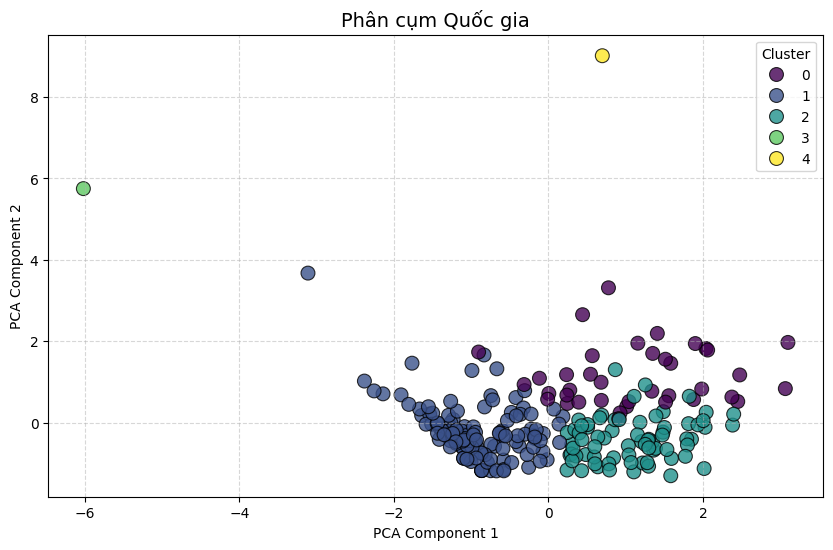

In [106]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1], 
    hue=df_clustering['Cluster'], 
    palette='viridis', s=100, alpha=0.8, edgecolor='k'
)
plt.title('Phân cụm Quốc gia', fontsize=14)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


### 5.2 Đặc điểm cụm (Profile)

In [107]:
viz_df = df_clustering.copy()

# Chuyển đổi đơn vị từ /1M dân -> /100k dân (chia cho 10)
viz_df['Cases_per_100k'] = viz_df['Cases_per_1M'] / 10
viz_df['Deaths_per_100k'] = viz_df['Deaths_per_1M'] / 10

# Đổi tên cột cho ngắn gọn để hiển thị lên biểu đồ
viz_df = viz_df.rename(columns={
    'Fatality_Rate': 'CFR', 
    'Avg_Growth_Rate': 'Growth_Rate'
})

# Danh sách các chỉ số cần vẽ
metrics = ['Cases_per_100k', 'Deaths_per_100k', 'CFR', 'Growth_Rate']

cluster_means = viz_df.groupby('Cluster')[metrics].mean().reset_index()

print("=== BẢNG GIÁ TRỊ TRUNG BÌNH CÁC ĐẶC TRƯNG THEO CỤM ===")
print(cluster_means)

=== BẢNG GIÁ TRỊ TRUNG BÌNH CÁC ĐẶC TRƯNG THEO CỤM ===
   Cluster  Cases_per_100k  Deaths_per_100k        CFR  Growth_Rate
0        0    28891.871950       365.968661   1.694104    13.658825
1        1     4818.132900        45.243890   1.416669    11.872299
2        2    42636.966185       134.300499   0.355569     6.918534
3        3       30.324340         5.480975  18.074508    10.363547
4        4    26377.375617       274.689294   1.041382   391.061060


Biểu đồ Barchart

C:\Users\Admin\AppData\Local\Temp\ipykernel_14840\4222031293.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_means, x='Cluster', y=metric, ax=axes[i], palette='viridis')
C:\Users\Admin\AppData\Local\Temp\ipykernel_14840\4222031293.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_means, x='Cluster', y=metric, ax=axes[i], palette='viridis')
C:\Users\Admin\AppData\Local\Temp\ipykernel_14840\4222031293.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_means, x='Cluster', y=metric, ax=axes[i], palet

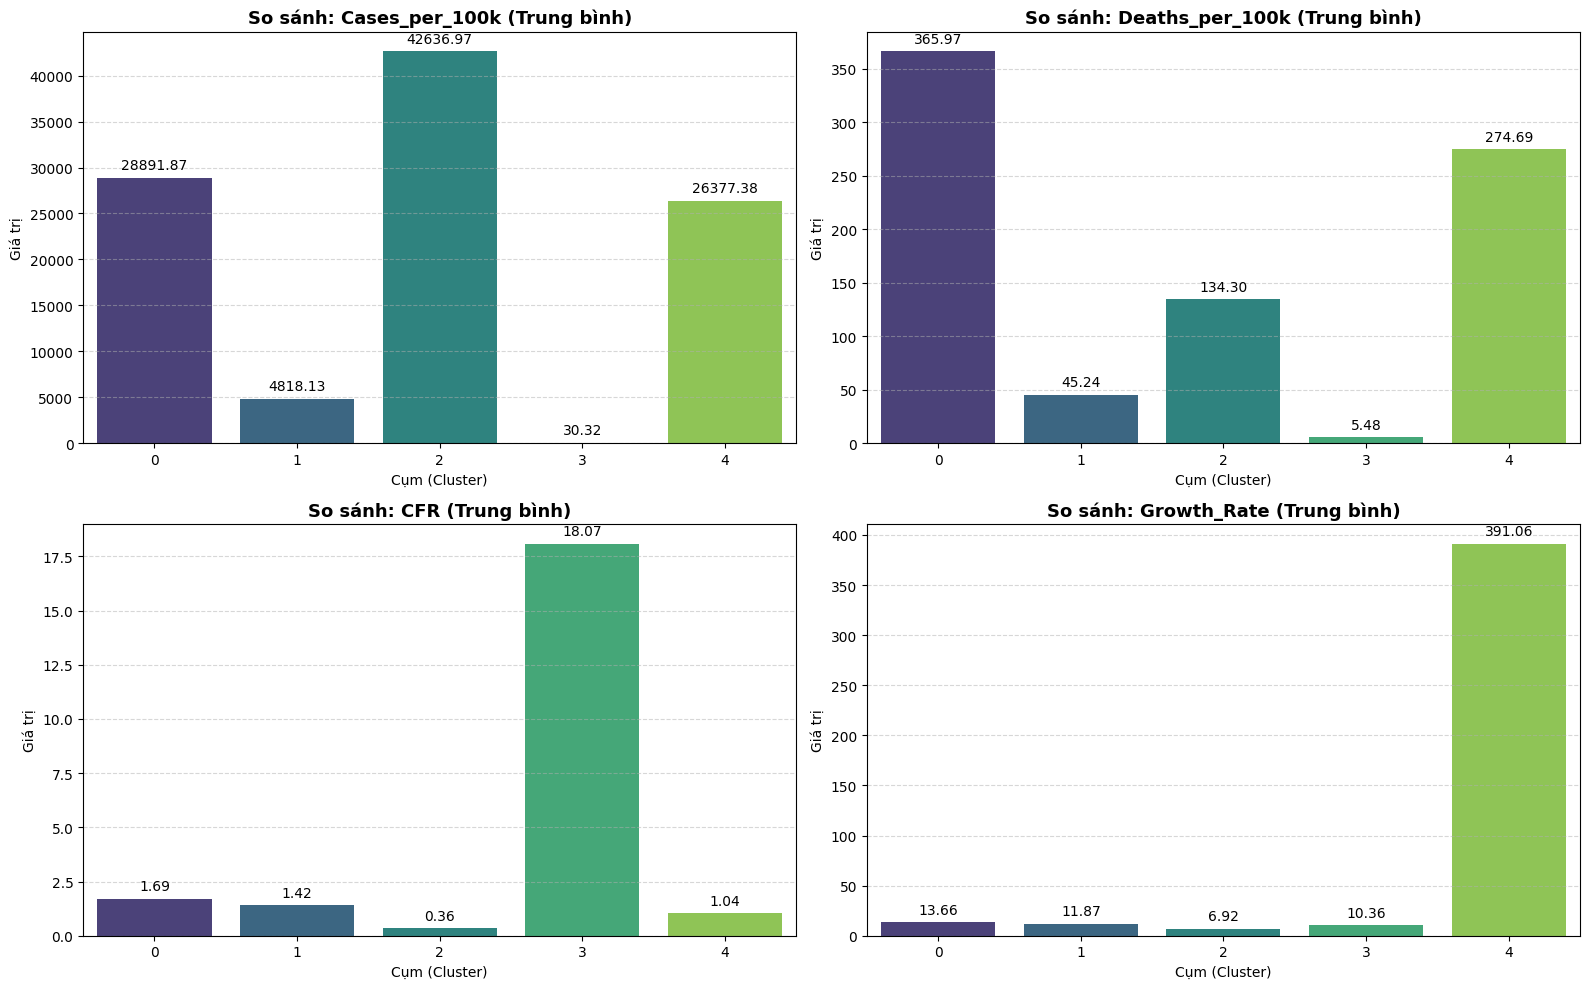

In [113]:

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten() # Làm phẳng mảng axes để dễ duyệt vòng lặp

colors = sns.color_palette("viridis", n_colors=len(cluster_means))

for i, metric in enumerate(metrics):
    # Vẽ Barplot
    sns.barplot(data=cluster_means, x='Cluster', y=metric, ax=axes[i], palette='viridis')
    
    # Trang trí biểu đồ
    axes[i].set_title(f'So sánh: {metric} (Trung bình)', fontsize=13, fontweight='bold')
    axes[i].set_xlabel('Cụm (Cluster)', fontsize=10)
    axes[i].set_ylabel('Giá trị', fontsize=10)
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)
    
    # Hiển thị giá trị trên đỉnh cột
    for p in axes[i].patches:
        axes[i].annotate(f'{p.get_height():.2f}', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points')

plt.tight_layout()
plt.show()

**Nhận xét:**
1. Về mức độ lây nhiễm (Cases_per_100k):

* Cụm 2 là nhóm có tỷ lệ lây nhiễm cao nhất (xấp xỉ 42.636 ca/100k dân), cao vượt trội so với các cụm còn lại. Điều này cho thấy đây là nhóm các quốc gia có độ phủ xét nghiệm rộng hoặc trải qua các đợt bùng phát mạnh mẽ.

* Cụm 0 và Cụm 4 cũng ghi nhận mức độ lây nhiễm cao (khoảng 26.000 - 28.000 ca/100k dân).

* Cụm 1 và Cụm 3 có số ca nhiễm ghi nhận rất thấp (đặc biệt Cụm 3 gần như không đáng kể về số ca nhiễm báo cáo).

2. Về mức độ tử vong (Deaths_per_100k):

* Cụm 0 là nhóm chịu ảnh hưởng nghiêm trọng nhất về nhân mạng với tỷ lệ tử vong cao nhất, đạt 365,97 ca/100k dân.

* Cụm 4 đứng thứ hai với 274,69 ca/100k dân.

* Đáng chú ý là Cụm 2, mặc dù có số ca nhiễm cao nhất (như đã phân tích ở trên), nhưng tỷ lệ tử vong lại ở mức trung bình (134,3 ca/100k dân), thấp hơn nhiều so với Cụm 0. Điều này gợi ý hệ thống y tế của nhóm này hoạt động hiệu quả, kiểm soát tốt tỷ lệ tử vong.

3. Về tỷ lệ tử vong trên ca nhiễm (CFR - Case Fatality Rate):

* Cụm 3 là một trường hợp ngoại lệ điển hình (Outlier) với chỉ số CFR cao bất thường, lên tới 18,07%. Trong khi số ca nhiễm báo cáo của cụm này rất thấp, tỷ lệ chết lại cực cao. Điều này phản ánh đặc điểm của các quốc gia đang khủng hoảng hoặc thiếu năng lực xét nghiệm, chỉ ghi nhận các ca bệnh nặng đã tử vong (như trường hợp Yemen đã thảo luận).

* Cụm 2 có chỉ số CFR thấp nhất (0,36%), củng cố giả thuyết đây là nhóm các nước phát triển, có tỷ lệ bao phủ vắc-xin cao và năng lực xét nghiệm diện rộng (phát hiện nhiều ca nhẹ nên mẫu số lớn, làm giảm CFR).

4. Về tốc độ tăng trưởng (Growth_Rate):

* Cụm 4 tách biệt hoàn toàn so với phần còn lại với tốc độ tăng trưởng trung bình lên tới 391,06. Đây là nhóm quốc gia đang đối mặt với làn sóng lây lan cực nhanh hoặc có sự thay đổi đột biến trong dữ liệu.

* Các cụm còn lại (0, 1, 2, 3) có tốc độ tăng trưởng thấp và ổn định (dưới 15), cho thấy dịch bệnh tại các nhóm này đã qua giai đoạn bùng nổ hoặc đang được kiểm soát.

Radar chart


=== BIỂU ĐỒ RADAR (Đã chuẩn hóa về thang đo 0-1) ===


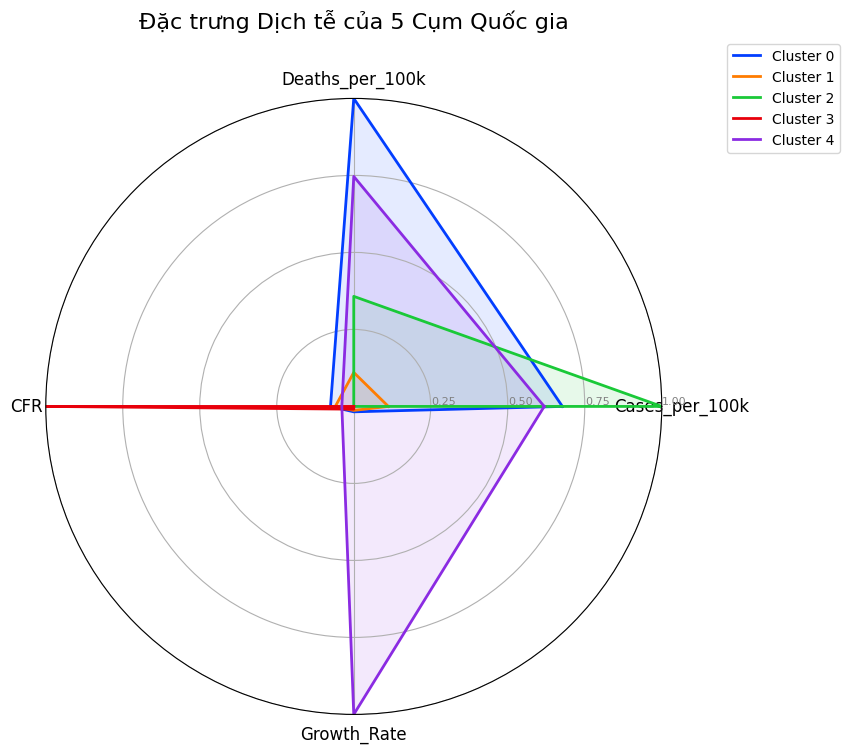

In [110]:
import numpy as np
from math import pi
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_radar_scaled = pd.DataFrame(scaler.fit_transform(cluster_means[metrics]), columns=metrics)
df_radar_scaled['Cluster'] = cluster_means['Cluster']

# 2. Hàm vẽ Radar Chart
def plot_radar_chart(df, categories, title):
    N = len(categories)
    
    # Góc của mỗi trục
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1] # Khép kín vòng tròn
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Vẽ từng cụm
    palette = sns.color_palette("bright", n_colors=len(df))
    
    for i, row in df.iterrows():
        values = row[categories].tolist()
        values += values[:1] # Khép kín vòng tròn
        
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {int(row["Cluster"])}', color=palette[i])
        ax.fill(angles, values, color=palette[i], alpha=0.1)
    
    # Thêm nhãn cho các trục
    plt.xticks(angles[:-1], categories, color='black', size=12)
    
    # Chỉnh trục y
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75, 1.0], ["0.25", "0.50", "0.75", "1.00"], color="grey", size=8)
    plt.ylim(0, 1)
    
    plt.title(title, size=16, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# Gọi hàm vẽ
print("\n=== BIỂU ĐỒ RADAR (Đã chuẩn hóa về thang đo 0-1) ===")
plot_radar_chart(df_radar_scaled, metrics, "Đặc trưng Dịch tễ của 5 Cụm Quốc gia")

**Nhận xét:** Biểu đồ Radar đã chứng minh tính đúng đắn của việc phân cụm đa chiều. Thay vì các cụm chồng lấn lên nhau, chúng ta thấy 5 "hướng đi" riêng biệt của dịch bệnh: Hướng tử vong cao (Cluster 0), hướng lây lan rộng (Cluster 2), hướng tăng trưởng nóng (Cluster 4), hướng bất thường dữ liệu (Cluster 3) và hướng ít ảnh hưởng (Cluster 1).

### 5.3 Xuất danh sách quốc gia đại diện


In [104]:
distances = kmeans.transform(X_scaled)
df_clustering['Distance_to_Center'] = np.min(distances, axis=1)

print("\n===QUỐC GIA ĐẠI DIỆN (GẦN TÂM NHẤT) ===")
for i in range(5):
    top_countries = df_clustering[df_clustering['Cluster'] == i].sort_values('Distance_to_Center').head(10)
    print(f"Cluster {i}: {top_countries['Country'].tolist()}")


===QUỐC GIA ĐẠI DIỆN (GẦN TÂM NHẤT) ===
Cluster 0: ['United States of America', 'Romania', 'Chile', 'Brazil', 'Argentina', 'United Kingdom of Great Britain and Northern Ireland', 'Slovakia', 'Trinidad and Tobago', 'Armenia', 'Russian Federation']
Cluster 1: ['Morocco', 'Nepal', 'India', 'Mauritania', 'Zambia', 'Venezuela (Bolivarian Republic of)', 'Bangladesh', 'Djibouti', 'Kyrgyzstan', 'Kenya']
Cluster 2: ['Isle of Man', 'Seychelles', 'Bonaire, Sint Eustatius and Saba', 'Bahrain', 'Israel', 'Saint Martin (French part)', 'Netherlands (Kingdom of the)', 'Australia', 'Switzerland', 'French Guiana']
Cluster 3: ['Yemen']
Cluster 4: ['Sweden']


### 5.4 Lựa chọn đại diện
* Cluster 0 (Nhóm "Tâm dịch lớn / Ảnh hưởng nghiêm trọng"): **United States of America**

    Lý do: Đứng đầu danh sách (gần tâm nhất), dữ liệu đầy đủ, trải qua nhiều làn sóng dịch, là ví dụ điển hình nhất.

* Cluster 1 (Nhóm "Các nước đang phát triển / Tác động tầm trung"): **India**

    Lý do: Dù đứng thứ 3 trong list nhưng Ấn Độ là đại diện tiêu biểu nhất cho nhóm này (đặc biệt là đợt bùng phát tháng 4/2021). Dữ liệu của Ấn Độ mang tính đại diện cao hơn Nepal hay Morocco.

* Cluster 2 (Nhóm "Thu nhập cao / Quy mô nhỏ & Y tế tốt"): **Israel**

    Lý do: Là quốc gia đi đầu thế giới về tiêm chủng và chiến lược "sống chung với dịch", rất hay được dùng làm case study.

* Cluster 3 (Nhóm "Ngoại lệ: Tỷ lệ tử vong bất thường" (Outlier)): **Yemen**

    Phân tích: Chỉ có 1 quốc gia. Yemen là một trường hợp đặc biệt (outlier) do chiến tranh, hệ thống y tế sụp đổ. Họ chỉ báo cáo các ca rất nặng, dẫn đến CFR (tỷ lệ tử vong) cực kỳ cao (có lúc lên tới 20-25%).

* Cluster 4 (Nhóm "Ngoại lệ: Chính sách khác biệt" (Outlier)): **Sweden**

    Phân tích: Chỉ có 1 quốc gia. Thụy Điển nổi tiếng toàn cầu vì đi ngược lại xu hướng chung: Không phong tỏa (No Lockdown), theo đuổi miễn dịch cộng đồng. Việc nó tách thành 1 cụm riêng chứng tỏ hành vi dịch tễ của nó rất khác biệt so với phần còn lại của Châu Âu.